# License 
***
Copyright (C) 2017 J. Patrick Hall, jphall@gwu.edu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

***
# Kaggle House Prices with GLRM Matrix Factorization Example

## Imports and inits

In [1]:
import h2o
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch 
h2o.init(max_mem_size='12G') # give h2o as much memory as possible
h2o.no_progress() # turn off h2o progress bars

import matplotlib as plt
%matplotlib inline
import numpy as np
import pandas as pd

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpd4usa_h6
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpd4usa_h6/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpd4usa_h6/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.1
H2O cluster version age:,2 months and 21 days
H2O cluster name:,H2O_from_python_phall_2hxc3t
H2O cluster total nodes:,1
H2O cluster free memory:,10.67 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


## Helper Functions

#### Determine data types

In [2]:
def get_type_lists(frame, rejects=['Id', 'SalePrice']):

    """Creates lists of numeric and categorical variables.
    
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    
    """
    
    nums, cats = [], []
    for key, val in frame.types.items():
        if key not in rejects:
            if val == 'enum':
                cats.append(key)
            else: 
                nums.append(key)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

#### Impute with GLRM

In [3]:
def glrm_num_impute(role, frame):

    """ Helper function for imputing numeric variables using GLRM.
    
    :param role: Role of frame to be imputed.
    :param frame: H2OFrame to be imputed.
    :return: H2OFrame of imputed numeric features.
    
    """
    
    # count missing values in training data numeric columns
    print(role + ' missing:\n', [cnt for cnt in frame.nacnt() if cnt != 0.0])

    # initialize GLRM
    matrix_complete_glrm = H2OGeneralizedLowRankEstimator(
        k=10,                    # create 10 features 
        transform='STANDARDIZE', # <- seems very important
        gamma_x=0.001,           # regularization on values in X
        gamma_y=0.05,            # regularization on values in Y
        impute_original=True)

    # train GLRM
    matrix_complete_glrm.train(training_frame=frame, x=original_nums)

    # plot iteration history to ensure convergence
    matrix_complete_glrm.score_history().plot(x='iterations', y='objective', title='GLRM Score History')

    # impute numeric inputs by multiply the calculated xi and yj for the missing values in train
    num_impute = matrix_complete_glrm.predict(frame)

    # count missing values in imputed set
    print('imputed ' + role + ' missing:\n', [cnt for cnt in num_impute.nacnt() if cnt != 0.0])
    
    return num_impute

#### Embed with GLRM 

In [4]:
def glrm_cat_embed(frame):
    
    """ Helper function for embedding caetgorical variables using GLRM.
    
    :param frame: H2OFrame to be embedded.
    :return: H2OFrame of embedded categorical features.
    
    """
    
    # initialize GLRM
    cat_embed_glrm = H2OGeneralizedLowRankEstimator(
        k=50,
        transform='STANDARDIZE',
        loss='Quadratic',
        regularization_x='Quadratic',
        regularization_y='L1',
        gamma_x=0.25,
        gamma_y=0.5)

    # train GLRM
    cat_embed_glrm.train(training_frame=frame, x=cats)

    # plot iteration history to ensure convergence
    cat_embed_glrm.score_history().plot(x='iterations', y='objective', title='GLRM Score History')

    # extracted embedded features
    cat_embed = h2o.get_frame(cat_embed_glrm._model_json['output']['representation_name'])
    
    return cat_embed

## Import data

In [5]:
train = h2o.import_file('../../03_regression/data/train.csv')
test = h2o.import_file('../../03_regression/data/test.csv')

# bug fix - from Keston
dummy_col = np.random.rand(test.shape[0])
test = test.cbind(h2o.H2OFrame(dummy_col))
cols = test.columns
cols[-1] = 'SalePrice'
test.columns = cols
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 81)


In [6]:
original_nums, cats = get_type_lists(train)

Numeric = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

Categorical = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',

## Split into to train and validation (before doing data prep!!!)

In [7]:
train, valid = train.split_frame([0.7], seed=12345)
print(train.shape)
print(valid.shape)

(1001, 81)
(459, 81)


## Impute numeric missing using GLRM matrix completion

#### Training data

training missing:
 [179.0, 7.0, 48.0]
imputed training missing:
 []


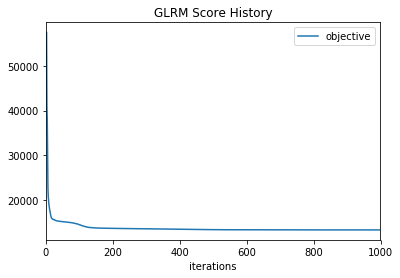

In [8]:
train_num_impute = glrm_num_impute('training', train)

In [9]:
train_num_impute.head()

reconstr_MSSubClass,reconstr_LotFrontage,reconstr_LotArea,reconstr_OverallQual,reconstr_OverallCond,reconstr_YearBuilt,reconstr_YearRemodAdd,reconstr_MasVnrArea,reconstr_BsmtFinSF1,reconstr_BsmtFinSF2,reconstr_BsmtUnfSF,reconstr_TotalBsmtSF,reconstr_1stFlrSF,reconstr_2ndFlrSF,reconstr_LowQualFinSF,reconstr_GrLivArea,reconstr_BsmtFullBath,reconstr_BsmtHalfBath,reconstr_FullBath,reconstr_HalfBath,reconstr_BedroomAbvGr,reconstr_KitchenAbvGr,reconstr_TotRmsAbvGrd,reconstr_Fireplaces,reconstr_GarageYrBlt,reconstr_GarageCars,reconstr_GarageArea,reconstr_WoodDeckSF,reconstr_OpenPorchSF,reconstr_EnclosedPorch,reconstr_3SsnPorch,reconstr_ScreenPorch,reconstr_PoolArea,reconstr_MiscVal,reconstr_MoSold,reconstr_YrSold
104.504,64.8044,6360.69,6.9754,5.17927,1997.99,1999.77,174.377,613.114,19.2989,253.903,886.316,945.281,793.879,8.95363,1748.11,0.733379,-0.0649383,1.86618,0.918167,2.87459,1.04048,7.00835,0.57749,2002.43,2.18697,573.498,128.382,50.5196,11.6872,-8.16975,0.356668,5.26623,-4.46426,4.10318,2008.79
19.4412,80.5638,21404.5,6.06692,7.70725,1962.9,1997.73,107.351,728.082,-14.1552,454.697,1168.62,1298.74,151.815,-2.08887,1448.47,0.369932,0.528449,1.43773,0.0490104,2.90186,0.839826,6.03521,0.716508,1970.88,1.55755,430.801,261.983,16.096,2.40177,36.5739,-38.8968,5.9997,52.2959,6.9103,2007.55
90.6237,68.2925,7259.58,7.03308,5.16735,1997.82,1997.44,178.618,584.487,-0.150073,370.745,955.081,1026.7,711.007,-12.868,1724.83,0.588434,0.0144578,1.8157,0.89706,2.79496,1.01207,6.81454,0.768934,1999.01,2.23034,579.877,91.7029,73.8497,-2.33926,2.78188,31.9139,2.71965,9.76937,7.31605,2007.56
86.669,84.7268,14097.6,7.81757,5.30479,2003.46,2004.68,277.549,761.973,9.03047,476.396,1247.4,1357.24,999.341,-19.8209,2336.76,0.629789,0.0798523,2.28589,1.0445,3.53589,1.10435,8.645,1.15543,2004.09,2.63527,691.52,156.579,102.906,-22.9468,8.42115,36.8409,10.9329,20.2672,8.4503,2007.31
92.3162,80.0501,8379.14,6.19802,6.42653,1988.03,1998.01,202.08,1100.92,-316.275,-3.37955,781.266,961.368,134.646,-63.4591,1032.55,0.688383,0.453183,1.33461,0.246228,1.79755,1.02575,4.4557,0.448428,1987.24,1.84721,483.131,100.752,-8.75176,-14.0468,62.0409,-15.29,-20.6762,-91.3456,10.8463,2006.59
47.3638,75.6473,16761.6,7.25111,5.25647,2004.64,2002.5,213.349,1145.91,69.0016,468.636,1683.55,1710.71,37.1101,0.00898378,1747.83,1.05894,0.114304,1.93063,0.0923605,2.56238,1.0485,6.64063,0.848451,2004.35,2.42649,690.301,187.859,72.3739,-11.067,15.0015,1.9677,19.8544,79.8152,7.44838,2007.4
72.8631,52.1558,8841.09,5.55062,4.72346,1926.14,1953.18,191.87,266.098,-128.907,972.483,1109.67,1377.28,534.304,32.6896,1944.27,0.0732666,-0.101733,1.63799,0.190902,3.60332,1.45341,8.33323,0.684233,1943.26,1.5906,425.14,-77.654,-12.5005,122.77,1.04417,18.503,12.6647,125.022,4.70042,2008.5
54.9512,70.2932,9518.92,4.97935,5.65433,1955.99,1971.32,39.217,712.248,82.7401,193.712,988.7,1108.28,-116.6,12.8143,1004.49,0.866169,-0.0198973,1.06864,-0.0243434,2.2786,1.09455,5.07327,0.336137,1964.39,1.30886,372.057,69.319,-0.349669,40.2895,-2.63471,5.66505,-0.93817,28.3024,4.27315,2008.84
92.7438,85.2366,16339.9,8.1064,5.17688,2003.59,2006.64,320.466,964.17,-19.175,496.493,1441.49,1547.68,1015.84,4.12377,2567.64,0.761821,0.100786,2.48515,0.890942,3.68423,1.17133,9.22112,1.15337,2006.4,2.74504,740.187,186.834,95.1685,0.332892,11.4106,8.06974,30.3652,36.9043,7.56584,2007.36
38.193,83.2008,10172.4,4.77541,5.88067,1955.03,1966.02,21.1455,730.585,123.219,56.9419,910.746,1043.41,-175.604,-34.585,833.219,0.858877,0.041454,0.779515,0.18209,2.0487,0.9927,4.40351,0.683735,1957.04,1.25507,344.403,22.3964,37.3544,1.97712,3.53325,75.4028,-15.3073,15.4705,8.31853,2007.66


#### Validation data

validation missing:
 [80.0, 1.0, 33.0]
imputed validation missing:
 []


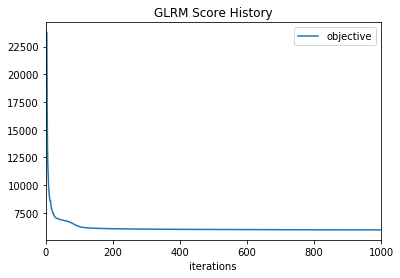

In [10]:
valid_num_impute = glrm_num_impute('validation', valid)

#### Test data

test missing:
 [227.0, 15.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 78.0, 1.0, 1.0]
imputed test missing:
 []


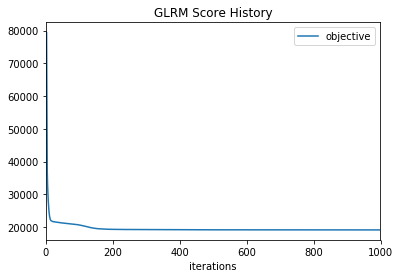

In [11]:
test_num_impute = glrm_num_impute('test', test)

## Embed categorical vars using GLRM

#### Training data

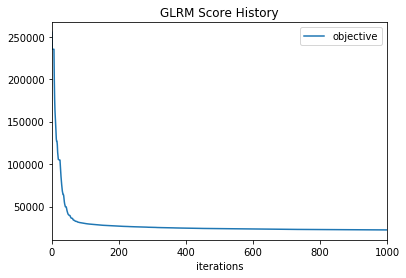

In [12]:
train_cat_embed = glrm_cat_embed(train)

#### Validation data

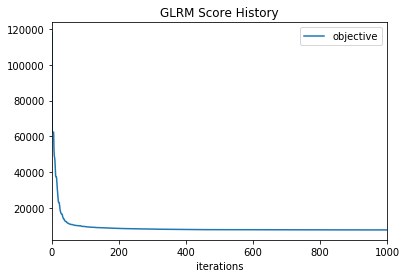

In [13]:
valid_cat_embed = glrm_cat_embed(valid)

#### Test data

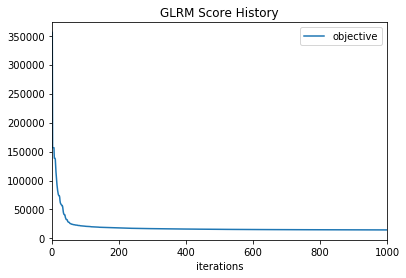

In [14]:
test_cat_embed = glrm_cat_embed(test)

## Merge imputed and embedded frames

In [15]:
imputed_embedded_train = train[['Id', 'SalePrice']].cbind(train_num_impute).cbind(train_cat_embed)
imputed_embedded_valid = valid[['Id', 'SalePrice']].cbind(valid_num_impute).cbind(valid_cat_embed)
imputed_embedded_test = test[['Id', 'SalePrice']].cbind(test_num_impute).cbind(test_cat_embed)

#### Redefine numerics and explore

In [16]:
imputed_embedded_nums, cats = get_type_lists(imputed_embedded_train)

Numeric = ['reconstr_MSSubClass', 'reconstr_LotFrontage', 'reconstr_LotArea', 'reconstr_OverallQual', 'reconstr_OverallCond', 'reconstr_YearBuilt', 'reconstr_YearRemodAdd', 'reconstr_MasVnrArea', 'reconstr_BsmtFinSF1', 'reconstr_BsmtFinSF2', 'reconstr_BsmtUnfSF', 'reconstr_TotalBsmtSF', 'reconstr_1stFlrSF', 'reconstr_2ndFlrSF', 'reconstr_LowQualFinSF', 'reconstr_GrLivArea', 'reconstr_BsmtFullBath', 'reconstr_BsmtHalfBath', 'reconstr_FullBath', 'reconstr_HalfBath', 'reconstr_BedroomAbvGr', 'reconstr_KitchenAbvGr', 'reconstr_TotRmsAbvGrd', 'reconstr_Fireplaces', 'reconstr_GarageYrBlt', 'reconstr_GarageCars', 'reconstr_GarageArea', 'reconstr_WoodDeckSF', 'reconstr_OpenPorchSF', 'reconstr_EnclosedPorch', 'reconstr_3SsnPorch', 'reconstr_ScreenPorch', 'reconstr_PoolArea', 'reconstr_MiscVal', 'reconstr_MoSold', 'reconstr_YrSold', 'Arch1', 'Arch2', 'Arch3', 'Arch4', 'Arch5', 'Arch6', 'Arch7', 'Arch8', 'Arch9', 'Arch10', 'Arch11', 'Arch12', 'Arch13', 'Arch14', 'Arch15', 'Arch16', 'Arch17', 'Arc

In [17]:
print('Imputed and encoded numeric training data:')
imputed_embedded_train.describe() 
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric validation data:')
imputed_embedded_valid.describe() 
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric test data:')
imputed_embedded_test.describe()

Imputed and encoded numeric training data:
Rows:1001
Cols:88




,Id,SalePrice,reconstr_MSSubClass,reconstr_LotFrontage,reconstr_LotArea,reconstr_OverallQual,reconstr_OverallCond,reconstr_YearBuilt,reconstr_YearRemodAdd,reconstr_MasVnrArea,reconstr_BsmtFinSF1,reconstr_BsmtFinSF2,reconstr_BsmtUnfSF,reconstr_TotalBsmtSF,reconstr_1stFlrSF,reconstr_2ndFlrSF,reconstr_LowQualFinSF,reconstr_GrLivArea,reconstr_BsmtFullBath,reconstr_BsmtHalfBath,reconstr_FullBath,reconstr_HalfBath,reconstr_BedroomAbvGr,reconstr_KitchenAbvGr,reconstr_TotRmsAbvGrd,reconstr_Fireplaces,reconstr_GarageYrBlt,reconstr_GarageCars,reconstr_GarageArea,reconstr_WoodDeckSF,reconstr_OpenPorchSF,reconstr_EnclosedPorch,reconstr_3SsnPorch,reconstr_ScreenPorch,reconstr_PoolArea,reconstr_MiscVal,reconstr_MoSold,reconstr_YrSold,Arch1,Arch2,Arch3,Arch4,Arch5,Arch6,Arch7,Arch8,Arch9,Arch10,Arch11,Arch12,Arch13,Arch14,Arch15,Arch16,Arch17,Arch18,Arch19,Arch20,Arch21,Arch22,Arch23,Arch24,Arch25,Arch26,Arch27,Arch28,Arch29,Arch30,Arch31,Arch32,Arch33,Arch34,Arch35,Arch36,Arch37,Arch38,Arch39,Arch40,Arch41,Arch42,Arch43,Arch44,Arch45,Arch46,Arch47,Arch48,Arch49,Arch50
type,int,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real
mins,1.0,34900.0,-44.23133635943228,-4225.097446464598,-3976.1018797495744,3.3997334226630325,3.544019257749243,1896.3503616847709,1945.6320773393284,-189.37297988096122,-309.9032975957491,-516.1675956709398,-636.8709708640919,236.1836160533884,384.6864969893868,-374.9063165857346,-79.36199875046046,344.8267735855611,-0.4168946840058124,-0.43105002779860335,0.5873209083623488,-0.6010367789160089,1.304756925088727,0.5264212471860051,2.7045369788879574,-0.7665386938905427,1924.5407928190298,0.4493128280616925,122.77719368752912,-111.44383054611383,-56.16776509169834,-74.50483748720302,-74.05947885021281,-146.4225090597484,-56.34296126166621,-690.7344165546625,-0.1067835864805371,2002.354095763163,-0.4687898220197418,-0.34360634991704014,-0.3045873955680723,-0.37940449690804373,-0.5116787657035613,-0.3873715788793161,-0.5551078336616105,-0.5101615979755374,-0.4566316170028562,-0.4142627287782314,-0.3701829969715028,-0.3809088576509194,-0.486780391952485,-0.41740843552411583,-0.4112451882631294,-0.4541860615984521,-0.6086107602024685,-0.3833517942843144,-0.5817784210121991,-0.6144218778576248,-0.3987088323519732,-0.4767109817088336,-0.3972698495578903,-0.35628115921299836,-0.4369454868451706,-0.3780863638592116,-0.3567010297649047,-0.37017008794301576,-0.4199215078967578,-0.4123033896708443,-0.40969484578613946,-0.5134560035054134,-0.3967699439253478,-0.41367767770234165,-0.41866197846637326,-0.4385784565849796,-0.34615708596196676,-0.40122567324152286,-0.3838900383470962,-0.40837401809828516,-0.3808997149099292,-0.4976501795001665,-0.35880479094503137,-0.34256394117821326,-0.3558649162592849,-0.3969736216143713,-0.5461651301619685,-0.5548373151931274,-0.3307883894827866,-0.3912157818295665
mean,724.8291708291708,182171.95904095905,56.99165174117779,67.85911675567769,10658.939424885144,6.138941714598302,5.589167678214504,1971.9775892138925,1984.9716074560897,107.0197713975476,446.0181071300255,41.36367763228622,575.4266876683594,1062.8084724306711,1172.3347866239785,342.1350869836496,5.893053022222092,1520.36292662985,0.4256049716205933,0.06033326119193199,1.5715953536698566,0.3811710120230708,2.8733196842312934,1.0475638619198469,6.515448194204085,0.6225314598923691,1978.4488302519555,1.7894501352005332,476.4975880873684,90.53910143697007,44.71366293407943,21.57793632388285,3.467119702006058,15.007357730135148,3.3962305155522667,49.87780208553257,6.362976999007829,2007.8283668583115,0.00611217477583627,0.01711433791626026,-0.002621626662746756,0

--------------------------------------------------------------------------------
Imputed and encoded numeric validation data:
Rows:459
Cols:88




,Id,SalePrice,reconstr_MSSubClass,reconstr_LotFrontage,reconstr_LotArea,reconstr_OverallQual,reconstr_OverallCond,reconstr_YearBuilt,reconstr_YearRemodAdd,reconstr_MasVnrArea,reconstr_BsmtFinSF1,reconstr_BsmtFinSF2,reconstr_BsmtUnfSF,reconstr_TotalBsmtSF,reconstr_1stFlrSF,reconstr_2ndFlrSF,reconstr_LowQualFinSF,reconstr_GrLivArea,reconstr_BsmtFullBath,reconstr_BsmtHalfBath,reconstr_FullBath,reconstr_HalfBath,reconstr_BedroomAbvGr,reconstr_KitchenAbvGr,reconstr_TotRmsAbvGrd,reconstr_Fireplaces,reconstr_GarageYrBlt,reconstr_GarageCars,reconstr_GarageArea,reconstr_WoodDeckSF,reconstr_OpenPorchSF,reconstr_EnclosedPorch,reconstr_3SsnPorch,reconstr_ScreenPorch,reconstr_PoolArea,reconstr_MiscVal,reconstr_MoSold,reconstr_YrSold,Arch1,Arch2,Arch3,Arch4,Arch5,Arch6,Arch7,Arch8,Arch9,Arch10,Arch11,Arch12,Arch13,Arch14,Arch15,Arch16,Arch17,Arch18,Arch19,Arch20,Arch21,Arch22,Arch23,Arch24,Arch25,Arch26,Arch27,Arch28,Arch29,Arch30,Arch31,Arch32,Arch33,Arch34,Arch35,Arch36,Arch37,Arch38,Arch39,Arch40,Arch41,Arch42,Arch43,Arch44,Arch45,Arch46,Arch47,Arch48,Arch49,Arch50
type,int,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real
mins,4.0,39300.0,-142.20322115479217,15.813018985836067,-23393.974655719067,2.379287728111687,2.8491948042188198,1869.1716746918141,1932.4861019288103,-244.1695218843334,-226.0544144524759,-294.9533908799977,-507.7457628406461,151.3645697509288,251.96510747210482,-240.9464647507753,-145.06831606760377,155.2333663873103,-0.3593072585406766,-0.3307167787076517,0.35428628652749894,-0.5860717658257095,1.258633310967037,0.4805323838887454,2.769738244796342,-0.358932031064913,1915.5531683621457,0.2769688350878632,34.823015841805216,-169.1087767899383,-281.185293100756,-68.54275892947936,-45.03716219474586,-95.86333913642486,-85.92802349304816,-921.1401634677385,-8.227871449289056,2005.7226262106904,-1.0215656807024331,-0.7942317071965307,-0.9125888234649776,-0.6810045110675549,-0.6623900944385468,-0.49307392916216125,-0.6425328542971805,-0.5691675579648764,-0.6823896127757941,-0.7096960065298188,-0.48315487097781684,-0.5910370307868622,-0.5261068414991021,-0.8019462498761715,-0.5515495981055787,-0.6984378634940565,-0.6655503451871528,-0.5020415331913689,-0.49278488834045553,-0.5896564547767593,-0.4392348709865277,-0.6773450283386849,-0.7887638542147085,-0.6044483414629664,-0.4427761774988994,-0.7121406669478941,-0.6925852300924551,-0.5549518215083713,-0.5017539005960532,-0.5304733326546767,-0.6334555572413609,-0.7113387044035526,-0.7677961407082217,-0.6345240419217852,-0.6088448222879502,-0.39341898201813497,-0.5255909821391301,-0.6390179429628006,-0.7180074907715046,-0.692995783726701,-0.8356807212628271,-0.5491594701710197,-0.47347449226829125,-0.9980502478397645,-0.6112586346175117,-0.6035618388247288,-0.5677431740668928,-0.6022443774755808,-0.6393056005307863,-0.8209632741799707
mean,742.8671023965142,178193.49673202613,56.23471301138956,69.07372396037331,10379.125564143755,5.987391284335328,5.564732490625868,1968.4631175571105,1983.961995931503,96.1879980143225,441.14533050081207,58.03422704204475,546.1083389763347,1045.2878965191912,1143.6863209682685,357.5452149598564,5.762195016154026,1506.993730944279,0.42420655445281946,0.05292721724723629,1.5408754135505383,0.38178597659827124,2.8624914023757886,1.0472096707832133,6.536084359375435,0.5990237781067325,1977.5095118008014,1.703704006643457,461.8934379606489,100.41585221799424,50.30035157539565,24.079442707741254,3.419460493734725,15.980950866493378,1.3043267934179072,53.75784261313451,6.229440796143993,2007.790933671356,0.027679665561754788,0.0238307399790329,0.03107720278479388,0.049103325

--------------------------------------------------------------------------------
Imputed and encoded numeric test data:
Rows:1459
Cols:88




,Id,SalePrice,reconstr_MSSubClass,reconstr_LotFrontage,reconstr_LotArea,reconstr_OverallQual,reconstr_OverallCond,reconstr_YearBuilt,reconstr_YearRemodAdd,reconstr_MasVnrArea,reconstr_BsmtFinSF1,reconstr_BsmtFinSF2,reconstr_BsmtUnfSF,reconstr_TotalBsmtSF,reconstr_1stFlrSF,reconstr_2ndFlrSF,reconstr_LowQualFinSF,reconstr_GrLivArea,reconstr_BsmtFullBath,reconstr_BsmtHalfBath,reconstr_FullBath,reconstr_HalfBath,reconstr_BedroomAbvGr,reconstr_KitchenAbvGr,reconstr_TotRmsAbvGrd,reconstr_Fireplaces,reconstr_GarageYrBlt,reconstr_GarageCars,reconstr_GarageArea,reconstr_WoodDeckSF,reconstr_OpenPorchSF,reconstr_EnclosedPorch,reconstr_3SsnPorch,reconstr_ScreenPorch,reconstr_PoolArea,reconstr_MiscVal,reconstr_MoSold,reconstr_YrSold,Arch1,Arch2,Arch3,Arch4,Arch5,Arch6,Arch7,Arch8,Arch9,Arch10,Arch11,Arch12,Arch13,Arch14,Arch15,Arch16,Arch17,Arch18,Arch19,Arch20,Arch21,Arch22,Arch23,Arch24,Arch25,Arch26,Arch27,Arch28,Arch29,Arch30,Arch31,Arch32,Arch33,Arch34,Arch35,Arch36,Arch37,Arch38,Arch39,Arch40,Arch41,Arch42,Arch43,Arch44,Arch45,Arch46,Arch47,Arch48,Arch49,Arch50
type,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real
mins,1461.0,0.0001814982952794697,-92.75778470357287,10.930200897692558,-1331.7437440363428,2.7557680251062204,1.868240863422876,1864.1153532298931,1932.0938228826237,-184.20590467074112,-552.6524354753168,-519.1425733897424,-640.9065878879742,274.36792343653315,354.2023858894753,-253.0861487190012,-64.50845998993184,421.25616104577375,-0.5911469065786003,-0.6181047947362193,0.517928673078881,-1.3406272361392029,1.243113879390776,0.4605552504885261,3.2790239835460437,-0.4818708110749761,1895.9367652220767,-1.17636214665974,-204.85938854263344,-120.25666603864205,-91.53961598374241,-79.84534653127818,-33.09633644933002,-275.2192382287285,-69.77069778988368,-1213.8628013317505,-3.9820654281458445,2003.6140682797518,-0.4166041778134264,-0.5226229663876257,-0.5644178793992695,-0.47746362379677,-0.6200476850509885,-0.542828977428711,-0.46725843619426594,-0.5610938046432569,-0.49975782202100105,-0.4685342114878999,-0.5324549963174952,-0.5249635202184685,-0.416823613619831,-0.4768342591557421,-0.5996960864774387,-0.4843235350358953,-0.3892974360979692,-0.6409060729692047,-0.3924330777074916,-0.6767115193350141,-0.6528612873280284,-0.6303654821458606,-0.51494528542572,-0.5006854901947662,-0.6180047495511283,-0.6611939646887504,-0.8045495784620555,-0.6492570321710167,-0.6338249495548767,-0.4793499957491692,-0.6615361022366946,-0.5944230484391473,-0.5671665579344716,-0.5373953230584934,-0.5247918641863867,-0.4924268389516594,-0.6156364210474966,-0.8511422382401028,-0.4917246780542121,-0.6385807551642991,-0.4416754934851361,-0.6267183132815487,-0.7069812994045146,-0.6044150159644555,-0.4803790575557538,-0.4218341603345212,-0.6539968807557834,-0.5007766031608373,-0.5234044238319067,-0.404778407713814
mean,2190.0,0.5001421069577299,56.950131445989044,68.87221929280068,9882.396951926889,6.065463343691031,5.558182218965061,1970.8923539282152,1983.3897953145033,100.63920599500369,439.8380462586054,52.77286746692447,553.1506803838961,1045.761594109426,1157.962767683342,325.87223687256983,3.603035344070155,1487.4380398999824,0.43537130247271927,0.0638972807556665,1.5671563237693258,0.37644594528130065,2.8600526473898964,1.043289750989343,6.393923735991169,0.583506381314772,1977.282970054829,1.7615189607156536,471.8775622777642,92.63687391732235,48.32429411962366,24.86457071839096,1.7805617652797048,17.385994544254288,1.7365025224936028,59.624624652248606,6.100535385316554,2007.7716467837663,0.022607935936278568,0.03413814300362256,0.0434464709643384,0.0553126

## Train model on imputed, embedded features

In [18]:
h2o.show_progress() # turn on progress bars

SalePrice
12.2477
12.109
12.3172


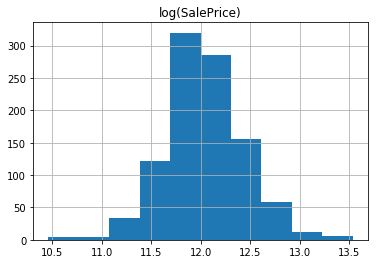

In [19]:
# Check log transform - looks good
%matplotlib inline
imputed_embedded_train['SalePrice'].log().as_data_frame().hist()

# Execute log transform
imputed_embedded_train['SalePrice'] = imputed_embedded_train['SalePrice'].log()
imputed_embedded_valid['SalePrice'] = imputed_embedded_valid['SalePrice'].log()
print(imputed_embedded_train[0:3, 'SalePrice'])

## Train GLM on imputed, embedded inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.99]  Grid_GLM_py_11_sid_acfd_model_python_1570481402793_13_model_4   
1     [0.5]  Grid_GLM_py_11_sid_acfd_model_python_1570481402793_13_model_3   
2    [0.25]  Grid_GLM_py_11_sid_acfd_model_python_1570481402793_13_model_2   
3    [0.01]  Grid_GLM_py_11_sid_acfd_model_python_1570481402793_13_model_1   

    residual_deviance  
0   12.38101208930572  
1  13.145568466431087  
2  14.063109332535952  
3   21.25550121078205  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_11_sid_acfd_model_python_1570481402793_13_model_4

GLM Model: summary



,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,"Elastic Net (alpha = 0.99, lambda = 0.04181 )","nlambda = 100, lambda.max = 0.3392, lambda.min = 0.04181, lambda.1se = -1.0",86,9,51,py_11_sid_acfd




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.03425063277769166
RMSE: 0.18506926481102057
MAE: 0.12023366724435518
RMSLE: 0.01422766263785756
R^2: 0.7791276936732663
Mean Residual Deviance: 0.03425063277769166
Null degrees of freedom: 1000
Residual degrees of freedom: 991
Null deviance: 155.22490791465145
Residual deviance: 34.28488341046935
AIC: -514.7093459469268

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 0.026973882547507017
RMSE: 0.16423727514637784
MAE: 0.11804303307594483
RMSLE: 0.0127038502868127
R^2: 0.8399320722377707
Mean Residual Deviance: 0.026973882547507017
Null degrees of freedom: 458
Residual degrees of freedom: 449
Null deviance: 77.67997881888829
Residual deviance: 12.38101208930572
AIC: -333.7291896477858
Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2019-10-07 17:00:07,0.000 sec,1,.34E0,1,0.1550698,0.1692374
,2019-10-07 17:00:07,0.002 sec,2,.32E0,2,0.1450761,0.1573254
,2019-10-07 17:00:07,0.005 sec,3,.31E0,2,0.1359661,0.1464519
,2019-10-07 17:00:07,0.007 sec,4,.29E0,2,0.1276618,0.1365261
,2019-10-07 17:00:07,0.009 sec,5,.28E0,2,0.1200921,0.1274650
---,---,---,---,---,---,---,---
,2019-10-07 17:00:07,0.104 sec,47,.4E-1,11,0.0338553,0.0270511
,2019-10-07 17:00:07,0.107 sec,48,.38E-1,11,0.0334654,0.0271464
,2019-10-07 17:00:07,0.109 sec,49,.36E-1,12,0.0330818,0.0273076
,2019-10-07 17:00:07,0.111 sec,50,.35E-1,12,0.0327220,0.0275058



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,11.9362
12.2061,12.2679
11.6784,11.6511
11.7906,11.9147
11.9117,11.8721
11.9767,12.045
11.8451,11.6592
11.1346,11.409
11.914,11.8427
11.8845,12.0384


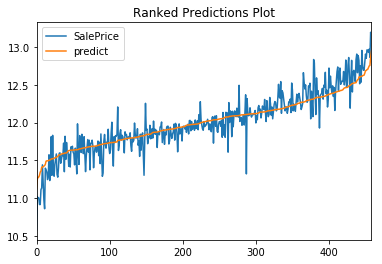

In [20]:
alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
hyper_parameters = {"alpha":alpha_opts}

# initialize grid search
grid = H2OGridSearch(
    H2OGeneralizedLinearEstimator(
        family="gaussian",
        lambda_search=True,
        seed=12345),
    hyper_params=hyper_parameters)
    
# train grid
grid.train(y='SalePrice',
           x=imputed_embedded_nums, 
           training_frame=imputed_embedded_train,
           validation_frame=imputed_embedded_valid)

# show grid search results
print(grid.show())

best = grid.get_grid()[0]
print(best)
    
# plot top frame values
yhat_frame = imputed_embedded_valid.cbind(best.predict(imputed_embedded_valid))
print(yhat_frame[0:10, ['SalePrice', 'predict']])

# plot sorted predictions
yhat_frame_df = yhat_frame[['SalePrice', 'predict']].as_data_frame()
yhat_frame_df.sort_values(by='predict', inplace=True)
yhat_frame_df.reset_index(inplace=True, drop=True)
_ = yhat_frame_df.plot(title='Ranked Predictions Plot')

In [21]:
# Shutdown H2O - this will erase all your unsaved frames and models in H2O
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_acfd closed.
